In [296]:
from IPython.display import display, HTML
css = !wget https://raw.githubusercontent.com/lapis-zero09/jupyter_notebook_tips/master/css/jupyter_notebook/monokai.css -q -O -
css = "\n".join(css)
display(HTML('<style type="text/css">%s</style>'%css))

In [297]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
import warnings
warnings.filterwarnings('ignore')
import lightgbm as lgb
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
import collections
from geopy.distance import geodesic


import os
from glob import glob
import seaborn as sns
from pandas_profiling import ProfileReport
from matplotlib_venn import venn2 
from pandas_profiling import ProfileReport
from contextlib import contextmanager
from time import time

In [298]:
class Timer:
    def __init__(self, logger=None, format_str="{:.3f}[s]", prefix=None, suffix=None, sep=" "):

        if prefix: format_str = str(prefix) + sep + format_str
        if suffix: format_str = format_str + sep + str(suffix)
        self.format_str = format_str
        self.logger = logger
        self.start = None
        self.end = None

    @property
    def duration(self):
        if self.end is None:
            return 0
        return self.end - self.start

    def __enter__(self):
        self.start = time()

    def __exit__(self, exc_type, exc_val, exc_tb):
        self.end = time()
        out_str = self.format_str.format(self.duration)
        if self.logger:
            self.logger.info(out_str)
        else:
            print(out_str)

In [299]:
%env DATA_ROOT ../COVID-19-Hospital-Stay-Prediction

env: DATA_ROOT=../COVID-19-Hospital-Stay-Prediction


In [300]:
glob("*")

['train.csv',
 'test.csv',
 'output',
 'README.md',
 'sample_submission.csv',
 'lgbm_baseline.ipynb']

In [301]:
INPUT_DIR = "../COVID-19-Hospital-Stay-Prediction/"
OUTPUT_DIR = "output/"

train = pd.read_csv(os.path.join(INPUT_DIR, "train.csv"))
train_df = pd.read_csv(os.path.join(INPUT_DIR, "train.csv"))
test_df = pd.read_csv(os.path.join(INPUT_DIR, "test.csv"))
sub_df = pd.read_csv(os.path.join(INPUT_DIR, "sample_submission.csv"))

In [302]:
#report = ProfileReport(train_df)
#report.to_file(os.path.join(OUTPUT_DIR, "train_report.html"))

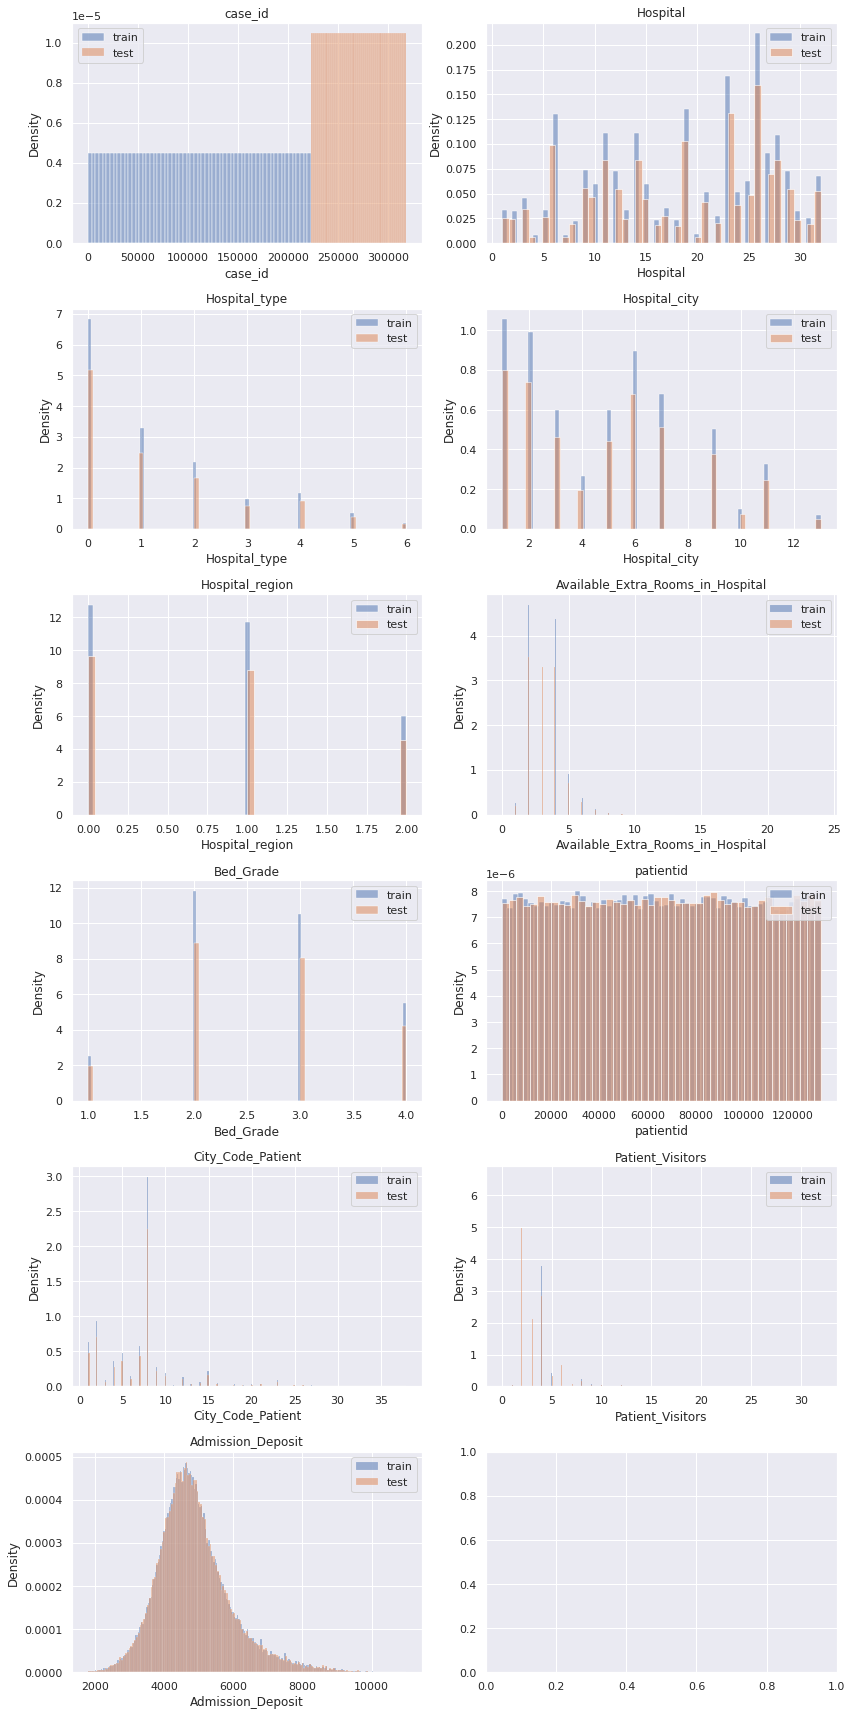

In [303]:
columns = test_df.columns[test_df.dtypes != "object"]
n_figs = len(columns)
n_cols = 2
n_rows = - (- n_figs // n_cols)

fig, axes = plt.subplots(figsize=(n_cols * 6, n_rows * 4), ncols=n_cols, nrows=n_rows)

for c, ax in zip(columns, axes.ravel()):
    sns.histplot(train_df[c], ax=ax, label="train", color="C0", alpha=.5, stat="density")
    sns.histplot(test_df[c], ax=ax, label="test", color="C1", alpha=.5, stat="density")
    ax.set_title(c)
    ax.legend()

fig.tight_layout()

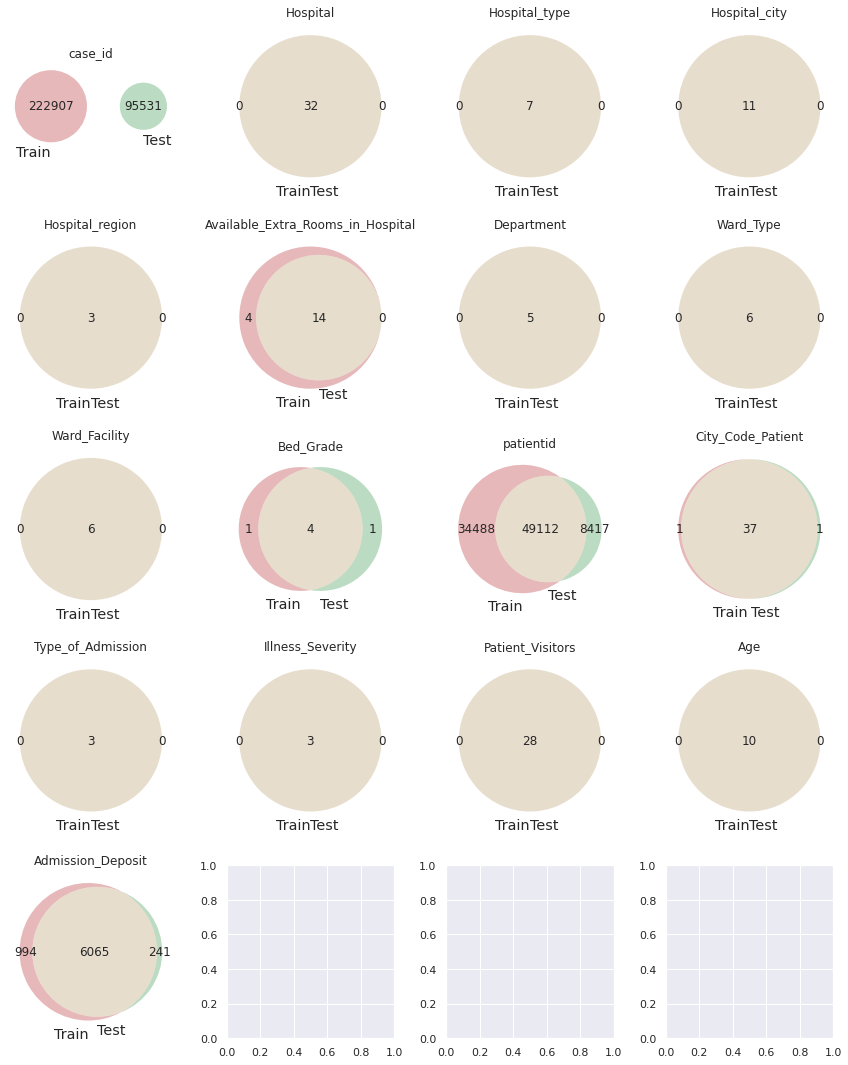

In [304]:
columns = test_df.columns
n_figs = len(columns)
n_cols = 4
n_rows = n_figs // n_cols + 1

fig, axes = plt.subplots(figsize=(n_cols * 3, n_rows * 3), ncols=n_cols, nrows=n_rows)

for c, ax in zip(columns, axes.ravel()):
    venn2(
        subsets=(set(train_df[c].unique()), set(test_df[c].unique())),
        set_labels=("Train", "Test"),
        ax=ax
    )
    ax.set_title(c)

fig.tight_layout()

In [305]:
train_df = train_df.drop('City_Code_Patient',axis=1)

In [306]:
def create_numeric_feature(input_df: pd.DataFrame) -> pd.DataFrame:
    use_columns = [
        "Hospital",
        "Hospital_type",
        "Hospital_city",
        "Hospital_region",
        "Available_Extra_Rooms_in_Hospital",
        "patientid",
        "Admission_Deposit"     
    ]

    return input_df[use_columns].copy()

In [307]:
for df in [train_df, test_df]:
    assert create_numeric_feature(df).equals(create_numeric_feature(df))

In [308]:
print(train_df.shape, test_df.shape)

(222907, 17) (95531, 17)


In [309]:
def data_pre(input_df: pd.DataFrame) -> pd.DataFrame:
    output_df = input_df.copy()
    
    counter = collections.Counter(output_df['Department'].values)
    count_dict = dict(counter.most_common())
    label_count_dict = {key:i for i, key in enumerate(count_dict.keys(), start=1)}
    encoded = output_df['Department'].map(lambda x: label_count_dict[x]).values
    output_df['Department'] = encoded
    
    counter = collections.Counter(output_df['Ward_Type'].values)
    count_dict = dict(counter.most_common())
    label_count_dict = {key:i for i, key in enumerate(count_dict.keys(), start=1)}
    encoded = output_df['Ward_Type'].map(lambda x: label_count_dict[x]).values
    output_df['Ward_Type'] = encoded
    
    counter = collections.Counter(output_df['Ward_Facility'].values)
    count_dict = dict(counter.most_common())
    label_count_dict = {key:i for i, key in enumerate(count_dict.keys(), start=1)}
    encoded = output_df['Ward_Facility'].map(lambda x: label_count_dict[x]).values
    output_df['Ward_Facility'] = encoded
    
    counter = collections.Counter(output_df['Type_of_Admission'].values)
    count_dict = dict(counter.most_common())
    label_count_dict = {key:i for i, key in enumerate(count_dict.keys(), start=1)}
    encoded = output_df['Type_of_Admission'].map(lambda x: label_count_dict[x]).values
    output_df['Type_of_Admission'] = encoded
    
    age = {
        "31-40":35,
        "41-50":45,
        "51-60":55,
        "21-30":25,
        "71-80":75,
        "61-70":65,
        "11-20":15,
        "81-90":85,
        "0-10":5,
        "91-100":95
    }
    output_df["Age"] = output_df["Age"].replace(age).astype(float)
    output_df['patientid'] = np.log1p(output_df['patientid'])
    output_df['Admission_Deposit'] = np.log1p(output_df['Admission_Deposit'])
    #output_df = output_df.drop('case_id', axis=1)
    
    #label encording
    return output_df

In [310]:
func = data_pre
for df in [train_df, test_df]:
    assert func(df).equals(func(df))

In [311]:
feature_functions = [
    create_numeric_feature,
    #data_pre
]

In [312]:
input_df = train_df

# 出力するデータフレームを空で用意して
out_df = pd.DataFrame()
print("start build features...")

# 各特徴生成関数ごとで
for func in feature_functions:

    # 特徴量を作成し
    _df = func(input_df)
    print(f"\t- {func.__name__}:\tn={','.join(_df.columns)}")

    # 横方向 (axis=1) にがっちゃんこ (concat) する
    out_df = pd.concat([out_df, _df], axis=1)

start build features...
	- create_numeric_feature:	n=Hospital,Hospital_type,Hospital_city,Hospital_region,Available_Extra_Rooms_in_Hospital,patientid,Admission_Deposit


In [313]:
from typing import List

def build_feature(input_df: pd.DataFrame, feature_functions: List) -> pd.DataFrame:
    # 出力するデータフレームを空で用意して
    out_df = pd.DataFrame()

    print("start build features...")

    # 各特徴生成関数ごとで
    for func in feature_functions:

        # 特徴量を作成し
        _df = func(input_df)
        print(f"\t- {func.__name__}:\tn={len(_df.T)}")

        # 横方向 (axis=1) にがっちゃんこ (concat) する
        out_df = pd.concat([out_df, _df], axis=1)

    return out_df

In [314]:
s_days = {
        "21-30":0,
        "11-20":1,
        "31-40":2,
        "51-60":3,
        "0-10":4,
        "41-50":5,
        "71-80":6,
        "101-":7,
        "81-90":8,
        "61-70":9,
        "91-100":10
    }
train_df["Stay_Days"] = train_df["Stay_Days"].replace(s_days).astype(float)

In [315]:
train["Stay_Days"] = train["Stay_Days"].replace(s_days).astype(float)

In [316]:
feat_train_df = build_feature(input_df=train_df, feature_functions=feature_functions)
feat_test_df = build_feature(input_df=test_df, feature_functions=feature_functions)

X, y = feat_train_df.values, train["Stay_Days"].values

start build features...
	- create_numeric_feature:	n=7
start build features...
	- create_numeric_feature:	n=7


In [318]:
assert len(feat_train_df.T) == len(feat_test_df.T)

In [319]:
from sklearn.model_selection import GroupKFold

fold = GroupKFold(n_splits=5)
cv = fold.split(X, y, groups=train_df['Hospital_type'].values)
cv = list(cv)

In [320]:
from sklearn.metrics import f1_score
import lightgbm as lgbm

def fit_lgbm(X, 
             y, 
             cv, 
             params: dict=None, 
             verbose: int=50):
    """lightGBM を CrossValidation の枠組みで学習を行なう function"""

    # パラメータがないときは、空の dict で置き換える
    if params is None:
        params = {}

    models = []
    n_records = len(X)
    n_labels = len(np.unique(y))
    # training data の target と同じだけのゼロ配列を用意
    oof_pred = np.zeros((n_records, n_labels), dtype=np.float32)

    for i, (idx_train, idx_valid) in enumerate(cv): 
        # この部分が交差検証のところです。データセットを cv instance によって分割します
        # training data を trian/valid に分割
        x_train, y_train = X[idx_train], y[idx_train]
        x_valid, y_valid = X[idx_valid], y[idx_valid]

        clf = lgbm.LGBMClassifier(**params)

        with Timer(prefix="fit fold={} ".format(i)):
            clf.fit(x_train, y_train, 
                    eval_set=[(x_valid, y_valid)],  
                    early_stopping_rounds=10,
                    verbose=verbose)

        pred_i = clf.predict_proba(x_valid)
        oof_pred[idx_valid] = pred_i
        models.append(clf)

        # 予測値は確率になっているので argmax でラベル化する
        y_pred_label = np.argmax(pred_i, axis=1)

        # 今回の指標の macro f1 で計算する
        score = f1_score(y_valid, y_pred_label, average="macro")
        print(f" - fold{i + 1} - {score:.4f}")

    oof_label = np.argmax(oof_pred, axis=1)
    score = f1_score(y, oof_label, average="macro")
    print(f"{score:.4f}")
    return oof_pred, models

In [321]:
params = {
    # 目的関数. これの意味で最小となるようなパラメータを探します. 
    "objective": "rmse", 

     # 学習率. 小さいほどなめらかな決定境界が作られて性能向上に繋がる場合が多いです、
    # がそれだけ木を作るため学習に時間がかかります
    "learning_rate": 0.1,

    # L2 Reguralization
    "reg_lambda": 1.,
    # こちらは L1 
    "reg_alpha": .1,

    # 木の深さ. 深い木を許容するほどより複雑な交互作用を考慮するようになります
    "max_depth": 5, 

    # 木の最大数. early_stopping という枠組みで木の数は制御されるようにしていますのでとても大きい値を指定しておきます.
    "n_estimators": 10000, 

    # 木を作る際に考慮する特徴量の割合. 1以下を指定すると特徴をランダムに欠落させます。小さくすることで, まんべんなく特徴を使うという効果があります.
    "colsample_bytree": .5, 

    # 最小分割でのデータ数. 小さいとより細かい粒度の分割方法を許容します.
    "min_child_samples": 10,

    # bagging の頻度と割合
    "subsample_freq": 3,
    "subsample": .9,

    # 特徴重要度計算のロジック(後述)
    "importance_type": "gain", 
    "random_state": 71,
}

In [322]:
oof, models = fit_lgbm(feat_train_df.values, train["Stay_Days"], params=params, cv=cv)

Training until validation scores don't improve for 10 rounds
[50]	valid_0's multi_logloss: 1.8126
Early stopping, best iteration is:
[48]	valid_0's multi_logloss: 1.81257
fit fold=0  1.486[s]
 - fold1 - 0.0850
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[27]	valid_0's multi_logloss: 1.94853
fit fold=1  1.242[s]
 - fold2 - 0.0698
Training until validation scores don't improve for 10 rounds
[50]	valid_0's multi_logloss: 1.90043
Early stopping, best iteration is:
[46]	valid_0's multi_logloss: 1.89991
fit fold=2  2.150[s]
 - fold3 - 0.0788
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[29]	valid_0's multi_logloss: 1.86155
fit fold=3  3.339[s]
 - fold4 - 0.0940
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[29]	valid_0's multi_logloss: 1.92612
fit fold=4  2.176[s]
 - fold5 - 0.0740
0.0816


In [323]:
oof_label = np.argmax(oof, axis=1)
scores = []
for i in range(11):
    y_binray = (y == i).astype(int)
    oof_label_i = np.where(oof_label == i, 1, 0)
    score_i = f1_score(y_binray, oof_label_i, average="binary")

    print(f" - {i} {score_i:.3f}")
    scores.append(score_i)

print(f"macro: {np.mean(scores):.3f}")

 - 0 0.448
 - 1 0.155
 - 2 0.069
 - 3 0.145
 - 4 0.059
 - 5 0.000
 - 6 0.000
 - 7 0.022
 - 8 0.000
 - 9 0.000
 - 10 0.000
macro: 0.082


In [324]:
f1_score(y, oof_label, average="macro") == np.mean(scores)

True

In [325]:
from sklearn.metrics import classification_report

print(classification_report(y, np.argmax(oof, axis=1)))

              precision    recall  f1-score   support

         0.0       0.31      0.83      0.45     61121
         1.0       0.21      0.12      0.15     54777
         2.0       0.20      0.04      0.07     38608
         3.0       0.21      0.11      0.14     24580
         4.0       0.15      0.04      0.06     16484
         5.0       0.00      0.00      0.00      8198
         6.0       0.00      0.00      0.00      7134
         7.0       0.17      0.01      0.02      4680
         8.0       0.00      0.00      0.00      3361
         9.0       0.00      0.00      0.00      1989
        10.0       0.00      0.00      0.00      1975

    accuracy                           0.28    222907
   macro avg       0.11      0.10      0.08    222907
weighted avg       0.21      0.28      0.19    222907



In [326]:
from typing import Optional, Tuple

from sklearn.metrics import confusion_matrix

def visualize_confusion_matrix(y_true,
                               pred_label,
                               ax: Optional[plt.Axes] = None,
                               labels: Optional[list] = None,
                               conf_options: Optional[dict] = None,
                               plot_options: Optional[dict] = None) -> Tuple[plt.Axes, np.ndarray]:
    """
    visualize confusion matrix
    Args:
        y_true:
            True Label. shape = (n_samples, )
        pred_label:
            Prediction Label. shape = (n_samples, )
        ax:
            matplotlib.pyplot.Axes object.
        labels:
            plot labels
        conf_options:
            option kwrgs when calculate confusion matrix.
            pass to `confusion_matrix` (defined at scikit-learn)
        plot_options:
            option key-words when plot seaborn heatmap
    Returns:
    """

    _conf_options = {
        "normalize": "true",
    }
    if conf_options is not None:
        _conf_options.update(conf_options)

    _plot_options = {
        "cmap": "Blues",
        "annot": True
    }
    if plot_options is not None:
        _plot_options.update(plot_options)

    conf = confusion_matrix(y_true=y_true,
                            y_pred=pred_label,
                            **_conf_options)

    if ax is None:
        fig, ax = plt.subplots(figsize=(10, 10))
    sns.heatmap(conf, ax=ax, **_plot_options)
    ax.set_ylabel("Label")
    ax.set_xlabel("Predict")

    if labels is not None:
        ax.set_yticklabels(labels)
        ax.set_xticklabels(labels)
        ax.tick_params("y", labelrotation=0)
        ax.tick_params("x", labelrotation=90)

    return ax, conf

(<AxesSubplot:xlabel='Predict', ylabel='Label'>,
 array([[50748,  6924,  1042,  1763,   604,     2,     0,    38,     0,
             0,     0],
        [43630,  6692,  1345,  2429,   644,     0,     0,    37,     0,
             0,     0],
        [27572,  5924,  1601,  2869,   624,     0,     0,    18,     0,
             0,     0],
        [14749,  4911,  1525,  2756,   601,     0,     0,    37,     0,
             1,     0],
        [11530,  2467,   785,  1061,   606,     0,     0,    35,     0,
             0,     0],
        [ 6233,   992,   313,   377,   261,     0,     0,    22,     0,
             0,     0],
        [ 4162,  1462,   487,   774,   220,     2,     0,    27,     0,
             0,     0],
        [ 2389,   867,   464,   620,   283,     1,     0,    55,     0,
             1,     0],
        [ 1722,   684,   322,   471,   145,     0,     0,    17,     0,
             0,     0],
        [ 1392,   285,    89,   115,    93,     0,     0,    15,     0,
             0,

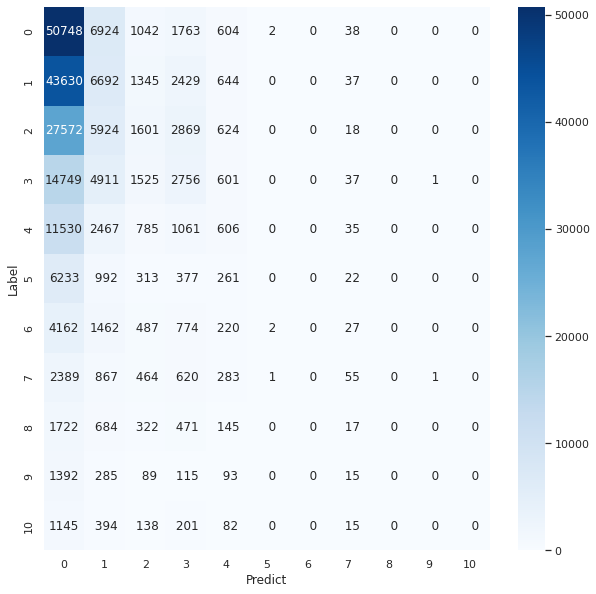

In [327]:
visualize_confusion_matrix(y, np.argmax(oof, axis=1), conf_options={ "normalize": None }, plot_options={ "fmt": "4d" })

In [328]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import OneHotEncoder, LabelEncoder

def check_y_and_pred(y_true, y_pred) -> (np.ndarray, np.ndarray, list):
    y_true = np.asarray(y_true)

    le = LabelEncoder()
    y_true = le.fit_transform(y_true)

    classes = le.classes_
    if len(classes) == 2:
        classes = classes[:-1]
    n_classes = len(classes)

    ohe = OneHotEncoder()
    y_true = ohe.fit_transform(y_true.reshape(-1, 1)).toarray()
    y_true = y_true[:, -n_classes:]
    y_pred = np.asarray(y_pred).reshape(-1, n_classes)
    return y_true, y_pred, classes


def visualize_roc_auc_curve(y_true, y_pred,
                            ax: Optional[plt.Axes] = None,
                            label_prefix: Optional[str] = None) -> [Optional[plt.Figure], plt.Axes]:
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    y_true, y_pred, classes = check_y_and_pred(y_true, y_pred)
    n_classes = len(classes)

    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_true[:, i], y_pred[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # Compute micro-average ROC curve and ROC area
    fpr["micro"], tpr["micro"], _ = roc_curve(y_true.ravel(), y_pred.ravel())
    roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

    if ax is None:
        fig, ax = plt.subplots(figsize=(10, 8))  # type: (plt.Figure, plt.Axes)
    else:
        fig, ax = None, ax  # type: (None, plt.Axes)

    for i in range(n_classes):
        label_i = f"label = {i} / area = {roc_auc[i]:.3f}"
        if label_prefix is not None:
            label_i = f"{label_prefix} {label_i}"
        ax.plot(fpr[i], tpr[i], label=label_i)
    ax.plot(np.linspace(0, 1), np.linspace(0, 1), "--", color="grey")
    ax.set_xlim(-.01, 1.01)
    ax.set_ylim(-.01, 1.01)
    ax.grid()
    ax.set_xlabel("False Positive Rate")
    ax.set_ylabel("True Positive Rate")
    ax.set_title("ROC Auc Score")
    ax.legend(loc="lower right")
    return fig, ax

(<Figure size 720x576 with 1 Axes>,
 <AxesSubplot:title={'center':'ROC Auc Score'}, xlabel='False Positive Rate', ylabel='True Positive Rate'>)

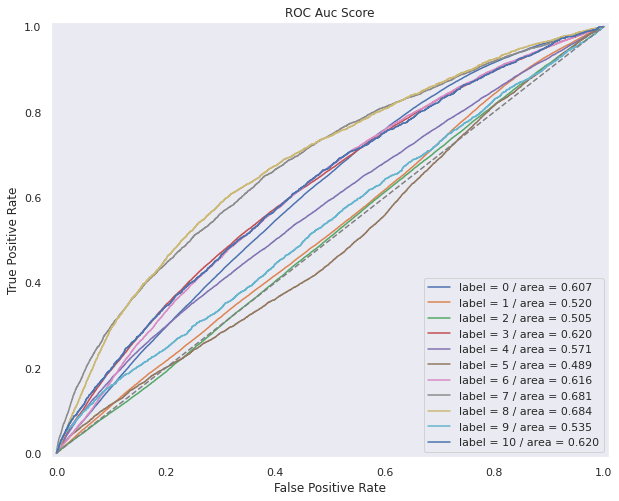

In [329]:
visualize_roc_auc_curve(y, oof)

In [330]:
from sklearn.metrics import precision_recall_curve, average_precision_score

def visualize_pr_curve(y_true, y_pred,
                            ax: Optional[plt.Axes] = None,
                            label_prefix: Optional[str] = None) -> [Optional[plt.Figure], plt.Axes]:
    precision = dict()
    recall = dict()
    pr_score = dict()
    y_true, y_pred, classes = check_y_and_pred(y_true, y_pred)
    n_classes = len(classes)

    for i in range(n_classes):
        precision[i], recall[i], _ = precision_recall_curve(y_true[:, i], y_pred[:, i])
        pr_score[i] = average_precision_score(y_true[:, i], y_pred[:, i])

    if ax is None:
        fig, ax = plt.subplots(figsize=(10, 10))
    else:
        fig, ax = None, ax

    for i in range(n_classes):
        label_i = f"label = {i} / area = {pr_score[i]:.3f}"
        if label_prefix is not None:
            label_i = f"{label_prefix} {label_i}"
        ax.plot(recall[i], precision[i], label=label_i)

    ax.set_xlim(-.01, 1.01)
    ax.set_ylim(-.01, 1.01)
    ax.grid()
    ax.set_xlabel("Recall")
    ax.set_ylabel("Precision")
    ax.set_title("Precision Recall Curve")
    ax.legend(loc="lower left")
    return fig, ax

(<Figure size 720x720 with 1 Axes>,
 <AxesSubplot:title={'center':'Precision Recall Curve'}, xlabel='Recall', ylabel='Precision'>)

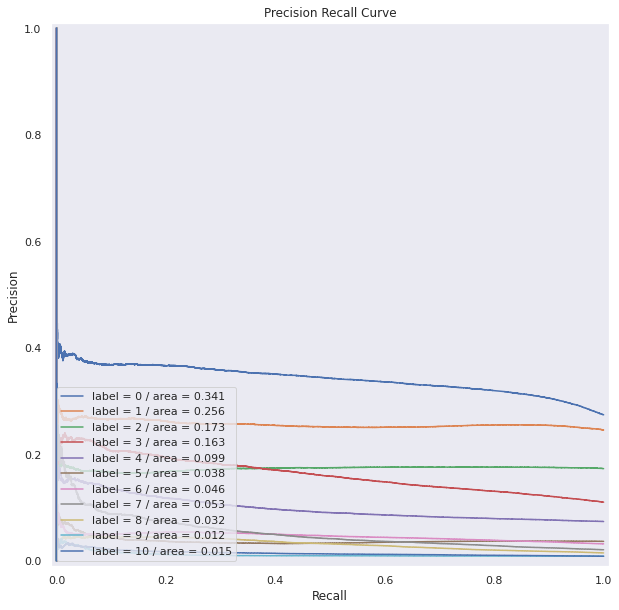

In [331]:
visualize_pr_curve(y, oof)

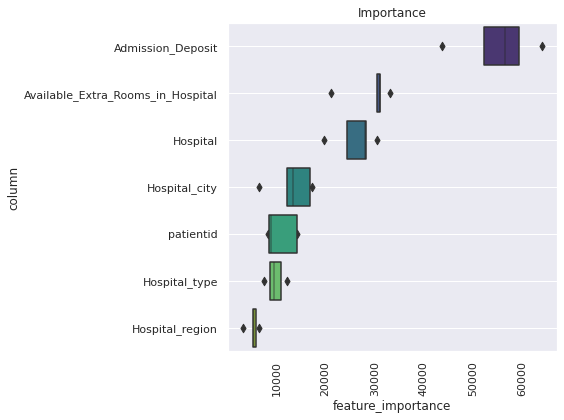

In [332]:
def visualize_importance(models, feat_train_df):
    """lightGBM の model 配列の feature importance を plot する
    CVごとのブレを boxen plot として表現します.

    args:
        models:
            List of lightGBM models
        feat_train_df:
            学習時に使った DataFrame
    """
    feature_importance_df = pd.DataFrame()
    for i, model in enumerate(models):
        _df = pd.DataFrame()
        _df["feature_importance"] = model.feature_importances_
        _df["column"] = feat_train_df.columns
        _df["fold"] = i + 1
        feature_importance_df = pd.concat([feature_importance_df, _df], 
                                          axis=0, ignore_index=True)

    order = feature_importance_df.groupby("column")\
        .sum()[["feature_importance"]]\
        .sort_values("feature_importance", ascending=False).index[:50]

    fig, ax = plt.subplots(figsize=(8, max(6, len(order) * .25)))
    sns.boxenplot(data=feature_importance_df, 
                  x="feature_importance", 
                  y="column", 
                  order=order, 
                  ax=ax, 
                  palette="viridis", 
                  orient="h")
    ax.tick_params(axis="x", rotation=90)
    ax.set_title("Importance")
    ax.grid()
    fig.tight_layout()
    return fig, ax

fig, ax = visualize_importance(models, feat_train_df)

In [334]:
# k 個のモデルの予測確率 (predict_proba) を作成. shape = (k, N_test, n_classes).
pred_prob = np.array([model.predict_proba(feat_test_df.values) for model in models])

# k 個のモデルの予測値の平均 shape = (N_test, n_classes).
pred_prob = np.mean(pred_prob, axis=0) # axis=0 なので shape の `k` が潰れる 

# 予測確率の最も高いものを句形のラベルとして設定. shape = (N_test,)
pred = np.argmax(pred_prob, axis=1) # axis=1 なので shape の `n_classes` の部分が潰れる
sub_df = pd.DataFrame({ "class_id": pred })
sub_df.to_csv(os.path.join(OUTPUT_DIR, "0001__submission.csv"), index=False)